In [1]:
!pip install ensemble-boxes

In [2]:
import os
import io
import json
import contextlib

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedGroupKFold

import pydicom
from pydicom import dcmread
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut

import cv2
from ensemble_boxes import *
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFont, ImageDraw

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [3]:
raw_df = pd.read_csv('../input/vinbigdata-chest-xray-abnormalities-detection/train.csv')
raw_df.sample(5)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
11157,417de085be6029490ca2690608d65e57,Cardiomegaly,3,R8,893.0,1461.0,1970.0,1968.0
27005,84baca7ccea00d8087be7b834603a5db,Infiltration,6,R10,1585.0,716.0,1953.0,1341.0
4360,82a054b42d1819ce1db9308915d843d1,No finding,14,R5,NaN,NaN,NaN,NaN
5215,529d855ec524ddf484434d90da0e3f4a,Nodule/Mass,8,R9,919.0,951.0,969.0,998.0
66752,9f3cd35d1e478da2bac4bf5afd1153c0,Aortic enlargement,0,R8,1297.0,900.0,1571.0,1296.0


image_id가 dicom 파일 이름이다. class_name은 No finding을 제외한 14개의 증상들이 입력되어있다. class_id에는 증상에 해당하는 번호가 부여되어있는데 찾지 못한 경우(No finding)은 14가 부여되어있다. rad_id는 방사선사의 id이고 x\_min, y\_min, x\_max, y\_max가 해당 증상이 탐지된 박스 범위이다.

In [4]:
ds = dcmread('/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/bd392937baf9a09b697937d8bb607989.dicom')
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 158
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: bd392937baf9a09b697937d8bb607989
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's Age                       AS: '060Y'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 2629
(0028, 0011) Columns                             US: 2179
(0028, 0100) Bits Allocate

# Get Image from dicom

의료용 영상들은 dicom 형태로 여러 특성들, 예를 들면 환자 정보나 의료 영상에 대한 정보를 포함하고 있다. 그 중에서 이미지 파일만 가져와서 사용한다.

In [4]:
CLIP_LIMIT = 2.
GRID_SIZE = (8, 8)
IMAGE_SIZE = 512

In [5]:
def read_image(fname, target_size=IMAGE_SIZE, use_clahe=True):
    """
    Arguments
        fname: 이미지를 가져오고 싶은 dicom 파일
        target_size: 목표 사이즈, 이미지의 가장 긴 길이가 이 길이보다 길다면
            비율을 유지한 채 이 길이로 맞춰준다.
        use_clahe: 블록별 히스토그램 균일화 사용 여부.
            이미지를 그리드 크기씩 나눈 다음 이 타일별로 이미지 균일화를 적용한다.
            균일화를 통해 픽셀값의 히스토그램이 치우쳐 있는 것을 보완한다.
    
    Returns
        img: dicom에서 가져온 이미지
        org_size: 원본 이미지의 크기
    """
    # read dicom file -> array
    ds = dcmread(fname)
    data = apply_voi_lut(ds.pixel_array, ds)
    
    # array normalize [0, 255]
    im = data - np.min(data)
    im = im / np.max(im) * 255.
    if ds.PhotometricInterpretation == 'MONOCHROME1': # 가장 낮은 값이 흰색
        im = 255. - im
        
    # Apply CLAHE, 블록별 히스토그램 균일화
    if use_clahe:
        clahe = cv2.createCLAHE(clipLimit=CLIP_LIMIT, tileGridSize=GRID_SIZE)
        cimg = clahe.apply(im.astype('uint8'))
        # array to image
        img = Image.fromarray(cimg.astype('uint8'), mode='L')  # mode='L': 8-bit pixels, white-black
    else:
        img = Image.fromarray(im.astype('uint8'), mode='L')
    
    org_size = img.size
    # Resize image if size larger than target size
    if max(img.size) > target_size:
        img.thumbnail((target_size, target_size), Image.Resampling.LANCZOS)
        
    return img, org_size

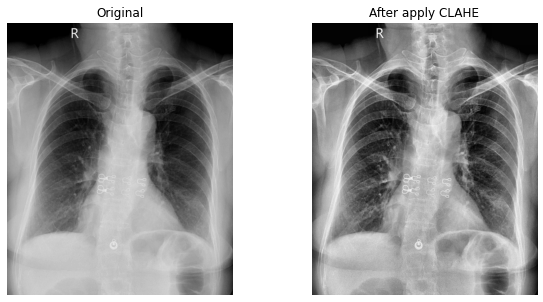

In [6]:
fname = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/bd392937baf9a09b697937d8bb607989.dicom"
img, size = read_image(fname, use_clahe=False)
img_clahe, size = read_image(fname)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axes[0].imshow(img, cmap='gray')
axes[0].set_title("Original")
axes[0].axis('off')
axes[1].imshow(img_clahe, cmap='gray')
axes[1].set_title("After apply CLAHE")
axes[1].axis('off')
plt.show()

원본 이미지는 보통 12bit의 해상도로 저장되는데 이를 8bit로 줄이면 데이터 이미지에 손실이 생길 수 있다. 16bit로 저장할 수도 있지만 여기서는 낮은 해상도로 낮출 때 손실을 줄이기 위해 Contrast Limiting Adaptive Histogram Equalization(CLAHE)를 사용한다. CLAHE는 블록별 히스토그램 균일화로, 이미지를 여러 블록으로 나눠 블록마다 픽셀 값들을 고르게 해주는 방법이다. CLAHE는 아래에서 픽셀 값들의 히스토그램을 보면 알 수 있듯이 한쪽으로 몰려 있는 값들을 비교적 평탄하게 만들어준다.

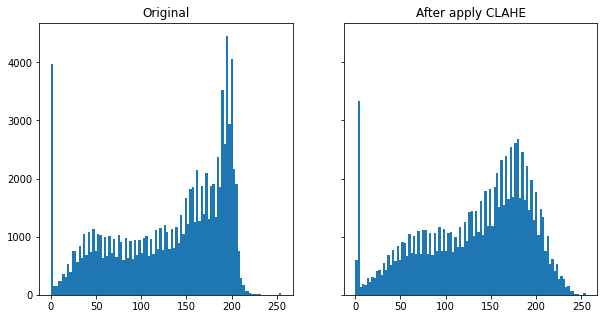

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axes[0].hist(np.random.choice(np.array(img).reshape(-1), 100000), bins=100)
axes[0].set_title("Original")
axes[1].hist(np.random.choice(np.array(img_clahe).reshape(-1), 100000), bins=100)
axes[1].set_title("After apply CLAHE")
plt.show()

# Plot Label Boxes

레이블을 확인하기 위해 xray 이미지 위에 박스를 그리는 함수를 정의한다.

In [8]:
# 분류 클래스 수와 클래스에 해당하는 박스 색 지정
NUM_CLASSES = 14
LABEL_COLORS = [(230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), 
                (245, 130, 48), (145, 30, 180), (70, 240, 240), (240, 50, 230), 
                (210, 245, 60), (250, 190, 212), (0, 128, 128), (220, 190, 255), 
                (170, 110, 40), (255, 250, 200), (128, 0, 0), (170, 255, 195), 
                (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), 
                (255, 255, 255), (0, 0, 0)]

In [9]:
class_name = raw_df[['class_name', 'class_id']].drop_duplicates().sort_values('class_id')
class_name = dict(zip(class_name['class_id'], class_name['class_name']))
class_name

{0: 'Aortic enlargement',
 1: 'Atelectasis',
 2: 'Calcification',
 3: 'Cardiomegaly',
 4: 'Consolidation',
 5: 'ILD',
 6: 'Infiltration',
 7: 'Lung Opacity',
 8: 'Nodule/Mass',
 9: 'Other lesion',
 10: 'Pleural effusion',
 11: 'Pleural thickening',
 12: 'Pneumothorax',
 13: 'Pulmonary fibrosis',
 14: 'No finding'}

## Plot Functions

In [10]:
def plot_boxes(img, box, label):
    alpha_bbox = 0.3
    alpha_textbox = 0.8
    overlay_bbox = img.copy() # Copy img to create bbox
    overlay_textbox = img.copy() # Copy img to create textbox
    output = img.copy() # Copy img to merge rectangles
    box = box.astype(int)
    label = int(label)

    # Create Bbox
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                  LABEL_COLORS[label], -1)
    # Merge Bbox to output image
    # (src1(rectangle), alpha1, src2(output), alpha2, gamma, dst(output))
    cv2.addWeighted(overlay_bbox, alpha_bbox, 
                    output, 1-alpha_bbox,
                    0, output)

    # Create Text box
    # Get text width and height for create textbox
    text_width, text_height = cv2.getTextSize(class_name[label],
                                              cv2.FONT_HERSHEY_SIMPLEX,
                                              0.7,
                                              1)[0]
    # Create textbox
    cv2.rectangle(overlay_textbox,
                  (box[0], box[1]-text_height-5),
                  (box[0]+text_width, box[1]),
                  LABEL_COLORS[label], -1)
    # Merge textbox to output image
    cv2.addWeighted(overlay_textbox, alpha_textbox,
                    output, 1-alpha_textbox,
                    0, output)

    # Add Bbox lines
    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                  LABEL_COLORS[label], thickness=3)

    # put text on textbox
    cv2.putText(output, class_name[label], 
                (box[0], box[1]-5),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7, (255, 255, 255), 1, cv2.LINE_AA)

    return output

In [11]:
def plot_ensembles(fname, idf):
    # Read image from fname(dicom)
    image, size = read_image(fname)
    # Convert Image to gray scale, regardless of cmap
    image = cv2.cvtColor(np.array(image), cv2.COLOR_GRAY2RGB)
    # Copy image to show difference after Ensembling Boxes
    image_nms = image.copy()
    image_softnms = image.copy()
    image_wbf = image.copy()
    
    # Get boxes and labels from idf
    # map box coordinates to resized image coordinates
    boxes = idf[['x_min', 'y_min', 'x_max', 'y_max']].values * IMAGE_SIZE / max(size)
    labels = idf['class_id'].values
    # Add boxes
    for box, label in zip(boxes, labels):
        image = plot_boxes(image, box, label)

    # Ensembling Boxes, Use Non-maximum suppression(NMS), Soft-NMS, Weighted boxes fusion(WBF)
    # Coordinates for boxes expected to be normalized 
    # e.g in range [0; 1]. Order: x1, y1, x2, y2.
    # https://github.com/ZFTurbo/Weighted-Boxes-Fusion
    boxes_norm = boxes / IMAGE_SIZE

    iou_thr = 0.45
    skip_box_thr = 0.0001
    sigma = 0.1
    
    boxes_nms, scores_nms, labels_nms = nms([boxes_norm],
                                            [np.ones(len(labels))],
                                            [labels],
                                            weights=None, 
                                            iou_thr=iou_thr)
    boxes_softnms, scores_softnms, labels_softnms = soft_nms([boxes_norm],
                                                             [np.ones(len(labels))],
                                                             [labels],
                                                             weights=None, 
                                                             iou_thr=iou_thr, 
                                                             sigma=sigma,
                                                             thresh=skip_box_thr)
    boxes_wbf, scores_wbf, labels_wbf = weighted_boxes_fusion([boxes_norm],
                                                              [np.ones(len(labels))],
                                                              [labels],
                                                              weights=None, 
                                                              iou_thr=iou_thr, 
                                                              skip_box_thr=skip_box_thr)
    # Denormalize boxes 
    boxes_nms *= IMAGE_SIZE
    boxes_softnms *= IMAGE_SIZE
    boxes_wbf *= IMAGE_SIZE
    # Add boxes
    for box, label in zip(boxes_nms, labels_nms):
        image_nms = plot_boxes(image_nms, box, label)
        
    for box, label in zip(boxes_softnms, labels_softnms):
        image_softnms = plot_boxes(image_softnms, box, label)
        
    for box, label in zip(boxes_wbf, labels_wbf):
        image_wbf = plot_boxes(image_wbf, box, label)

    # plot
    plt.figure(figsize=(20, 8))
    for i, (title, ensemble) in enumerate(zip(['Original', 'NMS', 'Soft-NMS', 'WBF'], 
                                              [image, image_nms, image_softnms, image_wbf])):
        plt.subplot(1, 4, i+1)
        plt.title(title)
        plt.axis('off')
        plt.imshow(ensemble)

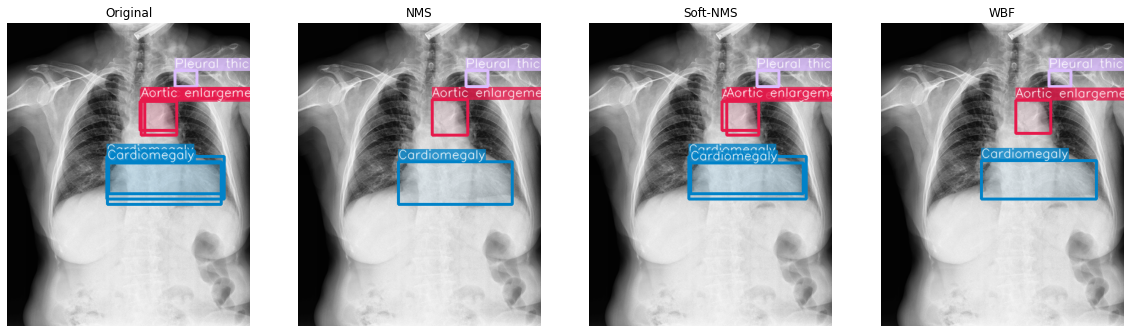

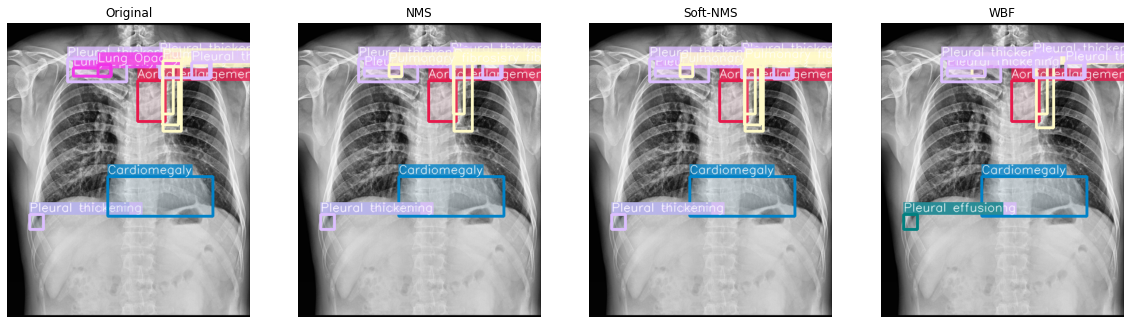

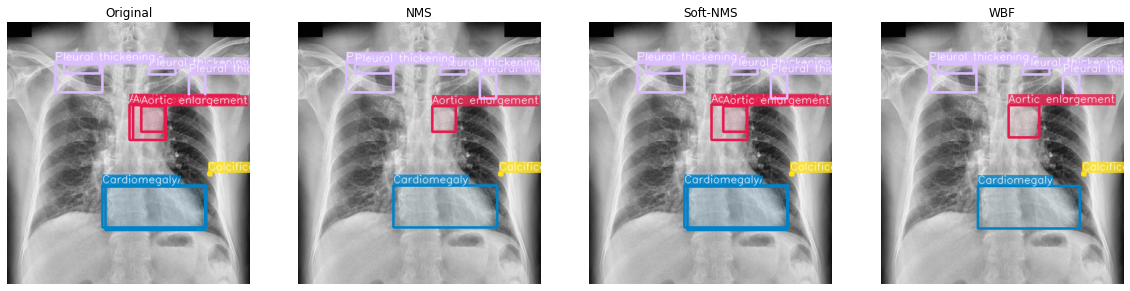

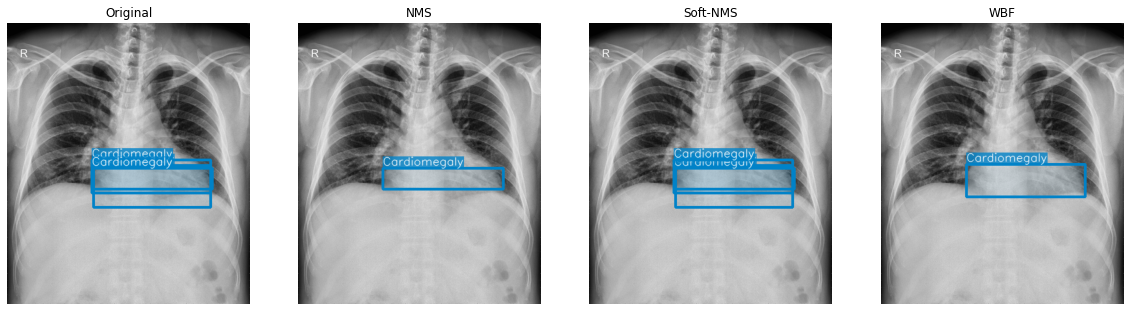

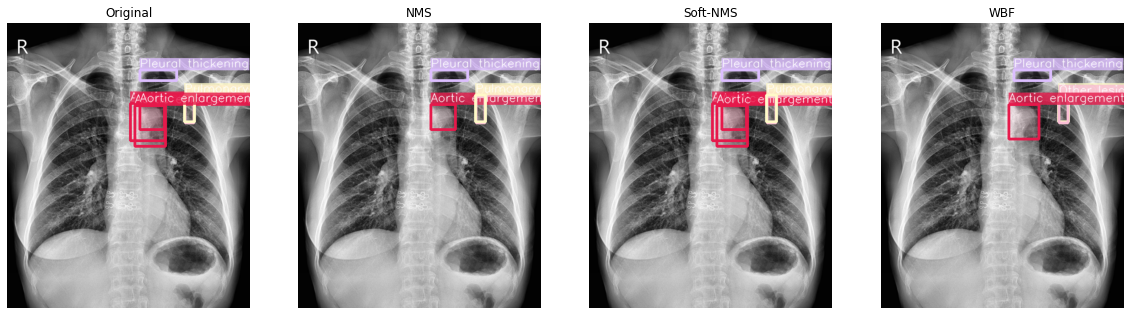

In [12]:
# Select xrays which has abnormalities
abnormals = raw_df[raw_df.class_id != 14]
abnormal_xrays = abnormals['image_id'].unique()

for i in [1, 101, 501, 1001, 2001]:
    # Get abnormal_xray index==i 
    # dataframe (boxes, labels)
    idf = raw_df[raw_df['image_id'] == abnormal_xrays[i]]
    # dicom file
    fname = '../input/vinbigdata-chest-xray-abnormalities-detection/train/' + abnormal_xrays[i] + '.dicom'
    # plot ensemble boxes sample
    plot_ensembles(fname, idf)

In [13]:
idf

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
5470,9c9d6d92f17ef2b3145ad8743e11b194,Aortic enlargement,0,R9,1349.0,882.0,1728.0,1290.0
18385,9c9d6d92f17ef2b3145ad8743e11b194,Other lesion,9,R10,1945.0,809.0,2042.0,1092.0
30762,9c9d6d92f17ef2b3145ad8743e11b194,Aortic enlargement,0,R8,1396.0,905.0,1736.0,1349.0
46879,9c9d6d92f17ef2b3145ad8743e11b194,Pleural thickening,11,R9,1452.0,517.0,1853.0,632.0
58828,9c9d6d92f17ef2b3145ad8743e11b194,Pulmonary fibrosis,13,R9,1942.0,789.0,2049.0,1083.0
60498,9c9d6d92f17ef2b3145ad8743e11b194,Aortic enlargement,0,R10,1456.0,890.0,1722.0,1169.0


이미지에 그려진 박스들을 보면 한 레이블에 여러 박스가 겹치는 경우가 있는 것을 볼 수 있다. 그리고 레이블이 표시된 데이터 프레임을 보면 여러 방사선사가 레이블을 표시해서 유사한 부분에 같은 증상으로 체크한 경우가 있다. 이 여러 박스들을 하나로 통합해 주는 작업이 필요해 보인다. 이는 객체 탐지를 할 때 Bouding box가 여러개 그려지면서 예측할 확률을 보여주는 것과 같게 볼 수 있다. 이때 여러 박스들을 합치는 방법에는 다음과 같은 것들이 있다.
- Non-maximum Suppression (NMS)
> 박스들의 Intersection over Uion (IoU) 값이 임계값보다 높다면 하나의 객체로 본다. 그래서 IoU 임계값에 의해서만 박스들이 필터링 되고 이는 성능 하락으로 이어진다. 그리고 가장 점수가 높은 박스만 남기고 다른 박스들은 제거하기 때문에 물체가 겹쳐있을 때 가장 점수가 높은 하나만 채택되고 나머지는 포함이 안 될 수도 있다.
- Soft-NMS
> 위 NMS를 보완한 방법으로 완전히 제거하는게 아니라 IoU 비율에 맞춰서 confidence 점수를 조정해준다. IoU(박스)가 많이 겹칠수록 더 낮춰준다. 박스가 많이 겹쳐서 특정 임계값을 넘긴다면 낮은 점수를 가진 박스를 제거해준다.
- Weighted Bboxes Fusion (WBF)
> WBF는 위 방법처럼 삭제하는 것과 달리 여러 박스들을 앙상블하는 방법이다. 하나의 객체에 대해 여러 박스들이 예측되었을 때 겹치는 부분의 IoU가 임계값보다 높은 박스들에 대해서 병합을 진행하다. 이 임계값을 넘기는 박스가 없을 때까지 진행한다. 박스의 좌표들은 병합 이전 각각의 박스들의 confidence score를 가중치로 해서 결정해준다. Confidence 점수는 사용된 박스들의 confidence 점수의 평균과 사용한 모델, 그리고 예측을 한 박스들의 수를 사용해 새로 지정해준다.

[WBF code](https://github.com/ZFTurbo/Weighted-Boxes-Fusion)

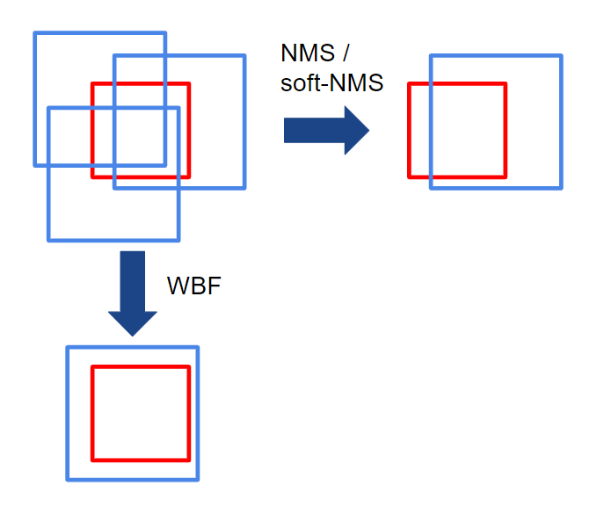

# Weighted Boundary box Fusion (WBF)

레이블이 있는 모든 xray 이미지에 WBF을 적용시켜즌다. 

In [14]:
wbf = []
for i in tqdm(range(len(abnormal_xrays))):
    idf = raw_df[raw_df['image_id']==abnormal_xrays[i]]
    boxes = idf[['x_min', 'y_min', 'x_max', 'y_max']].values
    boxes_norm = boxes / np.max(boxes)
    labels = idf['class_id'].values
    
    boxes_wbf, _, labels_wbf = weighted_boxes_fusion([boxes_norm],
                                                     [np.ones(len(labels))],
                                                     [labels],
                                                     weights=None,
                                                     iou_thr=0.45,
                                                     skip_box_thr=0.0001)
    boxes_wbf *= np.max(boxes)
    boxes_wbf = boxes_wbf.astype(int)
    for j in range(len(boxes_wbf)):
        wbf.append([abnormal_xrays[i], 
                    class_name[labels_wbf[j].astype(int)],
                    labels_wbf[j].astype(int),
                    boxes_wbf[j][0], boxes_wbf[j][1], 
                    boxes_wbf[j][2], boxes_wbf[j][3]])

  0%|          | 0/4394 [00:00<?, ?it/s]

In [15]:
wbf_df = pd.DataFrame(wbf, 
                      columns=['image_id', 'class_name', 'class_id',
                               'x_min', 'y_min', 'x_max', 'y_max'])

In [16]:
wbf_df.head()

,image_id,class_name,class_id,x_min,y_min,x_max,y_max
0,9a5094b2563a1ef3ff50dc5c7ff71345,Aortic enlargement,0,1052,715,1299,966
1,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural thickening,11,1789,1729,1875,1992
2,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural effusion,10,1789,1729,1875,1992
3,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,690,1354,1658,1797
4,051132a778e61a86eb147c7c6f564dfe,Pleural thickening,11,1592,452,1804,604


# Save Data

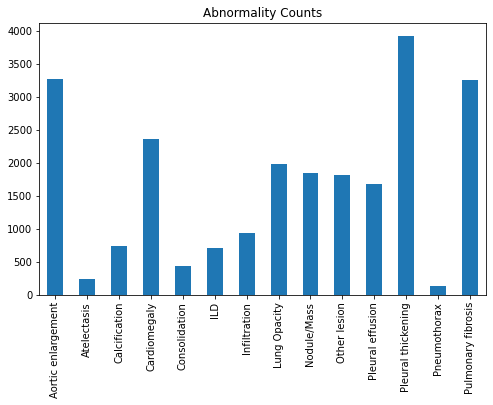

In [17]:
abnormality_counts = wbf_df['class_name'].value_counts().sort_index()
abnormality_counts.plot(kind='bar', figsize=(8, 5))
plt.title('Abnormality Counts')
plt.show()

모델을 훈련할 때는 이상 증상이 있다고 판단한 이미지들만 사용한다. 
위 그래프를 보면 증상들의 비율이 다 다른것을 볼 수 있다. 교차검증을 진행 할 때 위 분포에 유의해서 데이터들을 나눠야한다. 그리고 같은 사진은 같은 그룹에 포함되게 만들어서 검증데이터에 훈련데이터의 일부가 들어가 훈련이 잘못되는 것을 방지해야한다. 따라서 StratifiedGroupKFold를 이용해 데이터를 나눠준다.  
이미지 파일의 경우 이미지 파일 이외에 메타데이터나 레이블들이 파일에 저장되어 있는 경우가 있어 데이터를 읽는데 효율이 떨어지는 경우가 발생한다. Generator로 이미지를 배치사이즈씩 가져오더라도 속도가 제한적이다. 이를 방지함과 더불어 Tensorflow의 Object detection API를 사용하기 위해 TFRecords 형태로 저장해준다. 

## StratifiedGroupKFold

In [18]:
from sklearn.model_selection import StratifiedGroupKFold

N_SPLITS = 5
df_folds = wbf_df.copy()
df_folds['class_id'] += 1

In [19]:
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS,
                            shuffle=True,
                            random_state=42)

X = np.ones((len(wbf_df), 1))
y = df_folds['class_id']
groups = df_folds['image_id']

for i, (train_idx, valid_idx) in enumerate(sgkf.split(X, y, groups)):
    df_folds.loc[valid_idx, 'group'] = i
    
df_folds['group'] = df_folds['group'].astype(int)

In [20]:
df_folds.head()

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,group
0,9a5094b2563a1ef3ff50dc5c7ff71345,Aortic enlargement,1,1052,715,1299,966,0
1,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural thickening,12,1789,1729,1875,1992,0
2,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural effusion,11,1789,1729,1875,1992,0
3,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,4,690,1354,1658,1797,0
4,051132a778e61a86eb147c7c6f564dfe,Pleural thickening,12,1592,452,1804,604,2


In [21]:
df_folds.to_csv('train_wbf_fold.csv', index=False)

In [22]:
df_folds.groupby(['group', 'class_name']).count()['class_id'].unstack()

class_name,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis
group,,,,,,,,,,,,,,
0,668,54,150,475,90,132,197,427,340,379,354,784,25,650
1,652,48,119,473,75,145,183,375,378,342,324,758,28,663
2,668,37,176,466,100,130,187,412,350,388,327,826,25,629
3,636,47,172,479,71,177,191,350,463,364,316,746,31,661
4,651,44,119,460,96,122,169,409,316,332,356,810,20,644


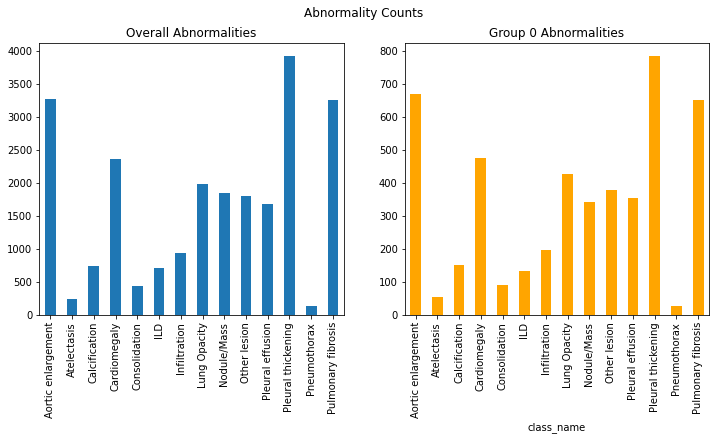

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

abnormality_counts = wbf_df['class_name'].value_counts().sort_index()
abnormality_counts.plot(kind='bar', ax=axes[0])

(df_folds.groupby(['group', 'class_name']).count()['class_id']
 .unstack().loc[0].plot(kind='bar', ax=axes[1], color='orange'))

plt.suptitle('Abnormality Counts')
axes[0].set_title('Overall Abnormalities')
axes[1].set_title("Group 0 Abnormalities")
plt.show()

## TFRecords

Reference:  
[Tensorflow TFRecord](https://www.tensorflow.org/tutorials/load_data/tfrecord#write_the_tfrecord_filehttps://www.tensorflow.org/tutorials/load_data/tfrecord#write_the_tfrecord_file)  
[2](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md)  
[Generate TFRecord example](https://github.com/datitran/raccoon_dataset/blob/master/generate_tfrecord.py)  
[ExitStack](https://docs.python.org/ko/3/library/contextlib.html#contextlib.ExitStackhttps://docs.python.org/ko/3/library/contextlib.html#contextlib.ExitStack)

In [24]:
DICOM_PATH = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/'

def create_tf_example(df, max_size=IMAGE_SIZE):
    # get dicom file from train dataframe and set metadata
    source_id = df['image_id'].values[0]
    
    fname = DICOM_PATH + source_id + '.dicom'
    
    filename = fname.split('/')[-1].encode()
    
    img, org_size = read_image(fname, target_size=max_size, use_clahe=True)
    
    height = img.size[1]
    width = img.size[0]
    
    # dicom 파일 가져와서 read_image -> Image 객체 
    # -> ByteIO (tfrecord: store sequence of binary records) -> tf example로 
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()
    
    img_format = b'png'

    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    
    classes_text = []
    classes = []
    
    for index, row in df.iterrows():
        xmins.append(row['x_min'] / org_size[0])
        xmaxs.append(row['x_max'] / org_size[0])
        ymins.append(row['y_min'] / org_size[1])
        ymaxs.append(row['y_max'] / org_size[1])
        
        classes_text.append(row['class_name'].encode()) # encode to byte
        classes.append(row['class_id'])
        
    # example 만들기  
    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[source_id.encode()])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_byte_arr])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_format])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes))
    }))
    
    return tf_example

In [25]:
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md

# with tf.io.TFRecordWriter('images.tfrecord') as writer:
#     ids = wbf_df['image_id'].unique()
#     for i in tqdm(range(len(ids))):
#         image_df = wbf_df[wbf_df['image_id']==ids[i]]
#         tf_example = create_tf_example(image_df)
#         writer.write(tf_example.SerializeToString())

def sgkf_tfrecords(stack, N_SPLITS): # contextlib.ExitStack() -> stack
    filenames = [f"Xray_abnormalities_{n+1:02d}_of_{N_SPLITS:02d}.tfrecord"
                 for n in range(N_SPLITS)] # N_SPLITS 개 파일 생성 (StratifiedGroupKFold)
    tfrecords = [stack.enter_context(tf.io.TFRecordWriter(filename))
                                     for filename in filenames] # TFRecordWriter 객체들
    return tfrecords

with contextlib.ExitStack() as stack: # 여러 파일 동시 처리
    # files = [stack.enter_context(open(fname)) for fname in filenames]
    tfrecords = sgkf_tfrecords(stack, N_SPLITS) # tfrecords에 TFRecordWriter 객체들 저장
    
    for n in tqdm(range(N_SPLITS)):
        sgkf_df = df_folds[df_folds['group']==n]
        ids = sgkf_df['image_id'].unique()
        
        for i in tqdm(range(len(ids)), leave=False):
            image_df = sgkf_df[sgkf_df['image_id']==ids[i]]
            tf_example = create_tf_example(image_df)
            tfrecords[n].write(tf_example.SerializeToString())

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/877 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/876 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

In [26]:
dicom_params = {
    "IMAGE_SIZE": IMAGE_SIZE,
    "CLIP_LIMIT": CLIP_LIMIT,
    "GRID_SIZE": GRID_SIZE}
with open("dicom_params.json", "w") as json_file:
    json_file.write(json.dumps(dicom_params, indent = 4))

In [27]:
labels = ['Aortic enlargement', 
          'Atelectasis', 
          'Calcification', 
          'Cardiomegaly', 
          'Consolidation',
          'ILD',
          'Infiltration', 
          'Lung Opacity', 
          'Nodule/Mass', 
          'Other lesion', 
          'Pleural effusion',
          'Pleural thickening',
          'Pneumothorax',
          'Pulmonary fibrosis']

with open('label_map.pbtxt', 'w') as f:
    for i in range (len(labels)): 
        f.write(f'item {{\n id: {i+1}\n name:\'{labels[i]}\'\n}}\n\n') 

# Test Image

In [28]:
DICOM_TEST_PATH = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/test/'
DICOM_LIST = os.listdir(DICOM_TEST_PATH)
os.makedirs('test_png', exist_ok=True)

In [29]:
def extract_image(dicom):
    fname = DICOM_TEST_PATH + dicom
    img, size = read_image(fname)
    return img, size

In [30]:
test = {}
test_image_id = []
test_org_width = []
test_org_height = []

for d in tqdm(DICOM_LIST):
    img, (width, height) = extract_image(d)
    test_org_width.append(width)
    test_org_height.append(height)
    d = d.split('.')[0]
    test_image_id.append(d)
    img.save(f'test_png/{d}.png')
        
test['image_id'] = test_image_id
test['width'] = test_org_width
test['height'] = test_org_height

test_data = pd.DataFrame(test)
test_data.to_csv('test_data.csv', index=False)

  0%|          | 0/3000 [00:00<?, ?it/s]